#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


##Lab. 03 - PyTorch regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Practical example: Linear Regression

Now let's solve the same problem analyzed in one of the previous lab using a simple neural network implemented in PyTorch.


# Data generation

Let's generate some data with our usual polynomial model, and save the data points in two csv files, one for training (train_data.csv), and one for validation (val_data.csv).

You can find these files in the "Files" section of Colab. They are not stored in your local machine, but they are stored remotely in the Colab server.

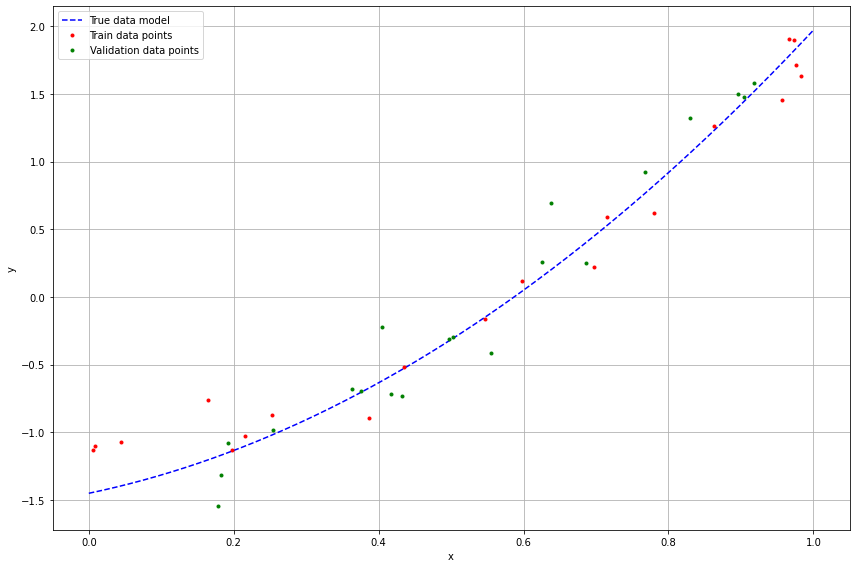

In [3]:
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
  data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
  f.write('\n'.join(data))
    
### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
  data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
  f.write('\n'.join(data))

  
### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Network Training

## Network Definition

Define a fully connected feed-forward network with 2 hidden layers.

Use a sigmoid activation function.

Since this is a regression, we do not want to limit the value of the output. For this reason, NO activation function should be used for the output layer.

In [4]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

## Dataset and Dataloader


We have already implemented the dataset class in the previous lab.

### Dataset

In [5]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and split the lines in a list
    with open(csv_file, 'r') as f:
      lines = f.read().split('\n')
    # Get x and y values from each line and append to self.data
    self.data = []
    for line in lines:
      sample = line.split(',')
      self.data.append((float(sample[0]), float(sample[1])))
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

### Transforms

In [6]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [7]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader

For the dataloader:

* enable the shuffling only for training data
* try different values for batch size
* disable the multiprocessing 

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Training loop

Now we put together all the steps analyzed in the previous lab:

In [9]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [10]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [11]:
# Define the loss function
loss_fn = nn.MSELoss()

In [12]:
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [13]:
### TRAINING LOOP
num_epochs = 1000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)
    

Görüntülenen çıkış son 5000 satıra kısaltıldı.
#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 1.510533332824707
AVERAGE VAL LOSS: 0.9322576522827148
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 1.29031503200531
AVERAGE VAL LOSS: 0.922944962978363
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 1.2670300006866455
AVERAGE VAL LOSS: 0.9662023782730103
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 1.2169142961502075
AVERAGE VAL LOSS: 0.9250325560569763
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 1.2024176120758057
AVERAGE VAL LOSS: 0.8890579342842102
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 1.1698516607284546
AVERAGE VAL LOSS: 0.8762878775596619
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 1.1881146430969238
AVERAGE VAL LOSS: 0.946232259273529
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 1.2178878784179688
AVERAGE VAL LOSS: 0

### Plot losses

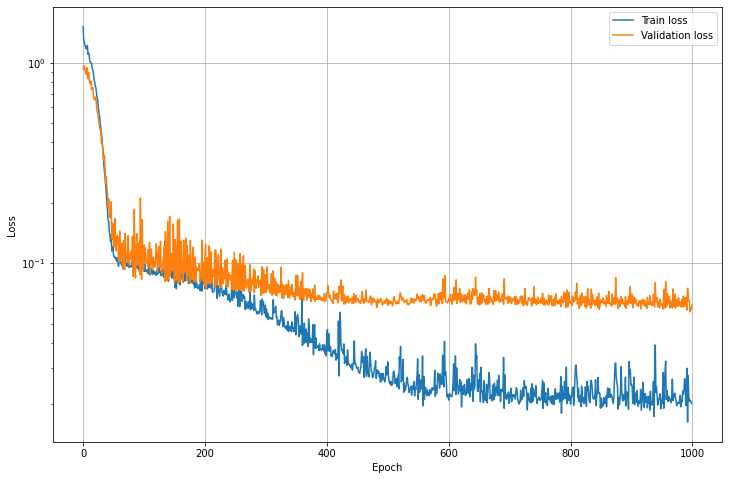

In [14]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Network analysis

## Network output

In [15]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
  y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


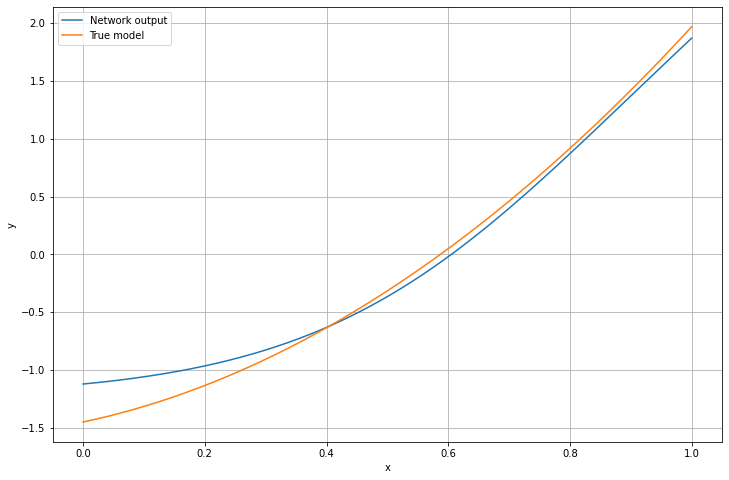

In [16]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Access network parameters

In [17]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

## Weights histogram

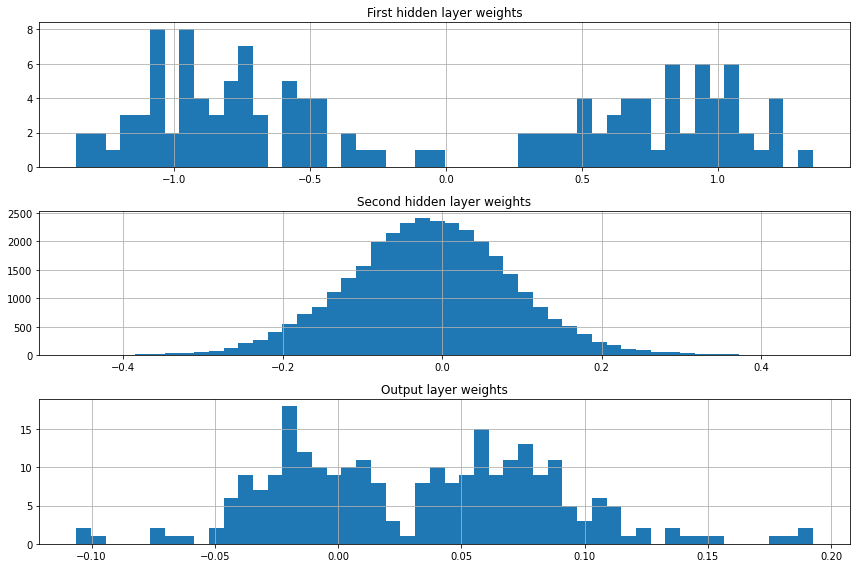

In [18]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Save network parameters

### Save network

In [19]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

### Load network

In [20]:
### Reload the network state
# First initialize the network (if not already done)
net = Net(Ni, Nh1, Nh2, No) 
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

## Save optimizer state
Also the optimizer has its internal state!

You need to save both the network and the optimizer states if you want to continue your training.

If you are sure you have finished your training you can just save the network.

In [21]:
### Save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state.torch')

### Reload the optimizer state
optimizer = optim.Adam(net.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

## Analyze activations

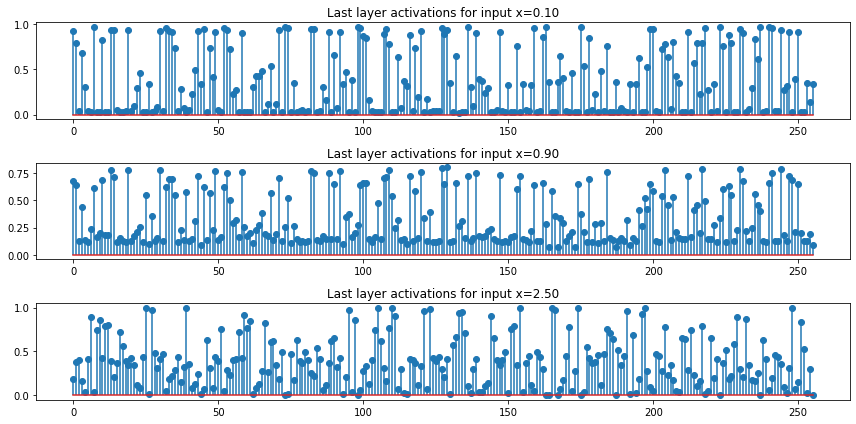

In [22]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Exercise - Classification model


**HINTS**
- Choose a loss function that is suitable for the specific problem, a binary classification in this case. If you keep a single linear output you can use a BCEWithLogitsLoss, which is more numerically stable than manually using a sigmoid output activation (more info here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).
- The network now has 2 inputs. A batched input should have a shape $\text{batch_size} \times 2$.
- The dataset should be adapted accordingly. Also consider to increase the batch size.
- Explore different optimizers, trying to understand the differences and their parameters (https://pytorch.org/docs/stable/optim.html).
- Try to increase the complexity of the network, and at the same time to introduce some regularization with dropout layers and/or weight decay (which is equivalent to an L2 regularization, typically implemented by the optimizer).
- Experiment with different hyper-parameters trying to minimize the VALIDATION LOSS. Once you are happy with the result, try the final test with the TEST dataset.

## Data generation

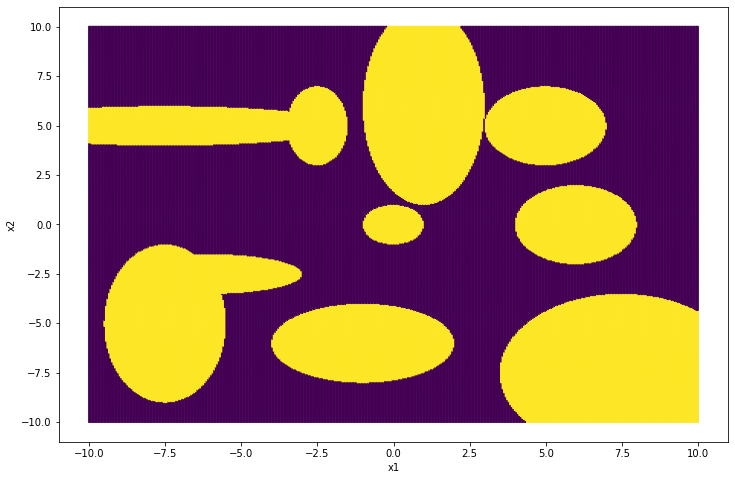

In [23]:
import itertools

np.random.seed(123)

def bidimensional_model(x1, x2):
  a = 1
  b = 1
  cx1 = 0
  cx2 = 0
  out = (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 2
  b = 2
  cx1 = 5
  cx2 = 5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 1
  b = 2
  cx1 = -2.5
  cx2 = 5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 3
  b = 1
  cx1 = -6
  cx2 = -2.5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 2
  b = 4
  cx1 = -7.5
  cx2 = -5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 6
  b = 1
  cx1 = -7.5
  cx2 = 5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 4
  b = 4
  cx1 = 7.5
  cx2 = -7.5
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 3
  b = 2
  cx1 = -1
  cx2 = -6
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 2
  b = 5
  cx1 = 1
  cx2 = 6
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  a = 2
  b = 2
  cx1 = 6
  cx2 = 0
  out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
  return out.astype(int)

### PLOT MODEL
# Input grid
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
x_prod = [x for x in itertools.product(x1, x2)]
x1 = np.array([x[0] for x in x_prod])
x2 = np.array([x[1] for x in x_prod])
# Evaluate out
y = bidimensional_model(x1, x2)
# Scatter plot
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=y, s=1, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.show()

### Training points

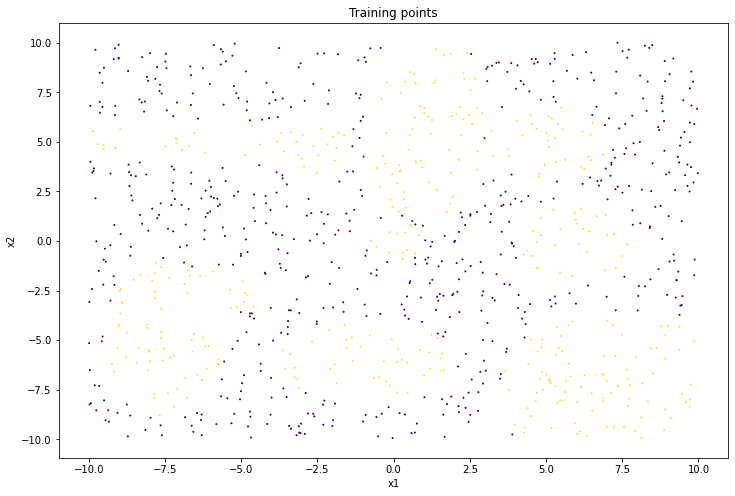

In [33]:
import pandas as pd

### Train data
num_points = 1000
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
train_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
train_df.to_csv('classifier_train_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=y, s=1, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Training points')
fig.show()

### Validation points

Validation points are randomly selected from the training points (20% in this case).

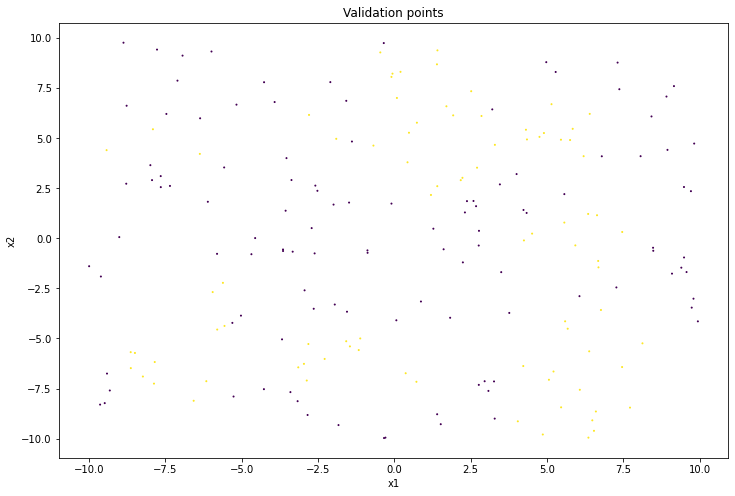

In [34]:
### Validation data
num_points = 200
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_val_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=y, s=1, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Validation points')
fig.show()

### Test points

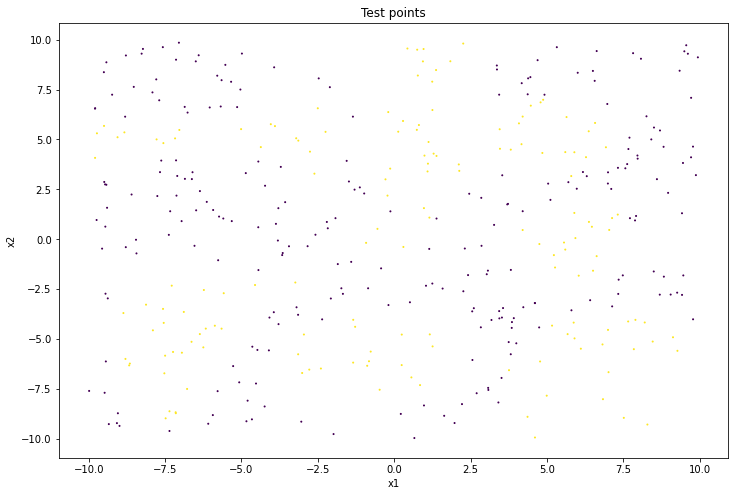

In [35]:
### Test data
num_points = 400
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_test_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=y, s=1, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Test points')
fig.show()

## Dataset and Dataloader

Define the dataset

In [36]:
class ClassifierDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and store the content in a pandas DataFrame
    self.df = pd.read_csv(csv_file)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.df)

  def __getitem__(self, idx):
    # Our sample is the row at index idx of the dataframe
    row = self.df.iloc[idx]
    # There are 2 inputs this time
    sample = ([row.x1, row.x2], row.y)
    if self.transform:
        sample = self.transform(sample)
    return sample

Define the transformations

In [37]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).float(),
                torch.Tensor([y]).float())

Initialize the datasets

In [38]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = ClassifierDataset('classifier_train_data.csv', transform=composed_transform)
val_dataset   = ClassifierDataset('classifier_val_data.csv', transform=composed_transform)
test_dataset  = ClassifierDataset('classifier_test_data.csv', transform=composed_transform)

Define the dataloaders

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

## Network definition

In [40]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

## Training loop

In [41]:
# Initialize the network
torch.manual_seed(0)
Ni = 2
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-2)

Network initialized


In [42]:
### TRAINING LOOP
num_epochs = 600
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.8192713856697083
AVERAGE VAL LOSS: 0.7717154622077942
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.6952048540115356
AVERAGE VAL LOSS: 0.756071150302887
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.6766839027404785
AVERAGE VAL LOSS: 0.6654766201972961
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.6524616479873657
AVERAGE VAL LOSS: 0.663502037525177
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.6430497169494629
AVERAGE VAL LOSS: 0.6598371863365173
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.6356865167617798
AVERAGE VAL LOSS: 0.6720980405807495
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.6299794316291809
AVERAGE VAL LOSS: 0.6480825543403625
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.6199522614479065
AVERAGE VAL LOSS: 0.6374214291572571
#################
# EPOCH 

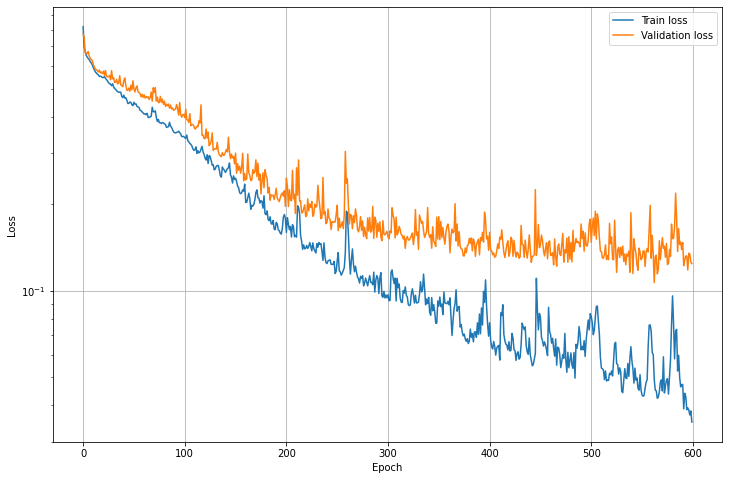

In [43]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Final test

Iterate the dataloader a single time and save all the outputs (in case you have multiple batches)

In [44]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.11944692581892014


In this case the network has a linear output (for a better stability of the loss function). 
To have probability estimates you can apply a sigmoid to the network output.

Since we just need the most probable class and we have a single output, we can consider the sign of the linear output. Negative output means that the class 0 is the most probable (probability < 50%), otherwise class 1 (probability > 50%).

Essentially this network estimates the probability of the input sample to be of class 1.

> **NOTE**
> 
> You can (and should, for practice) redefine the problem by defining a network with more than one output, each of them corresponding to a specific class (2 in this case). Since the two classes are mutually exclusive, the loss function should be a CrossEntropyLoss (softmax activation). In a multi-class scenario, a BCE loss is suitable when the classes are NOT mutually exclusive.






---


Get the most probable class inferred by the network


In [45]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes[all_outputs > 0] = 1

Evaluate the test accuracy

In [46]:
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 95.25%


Plot the results

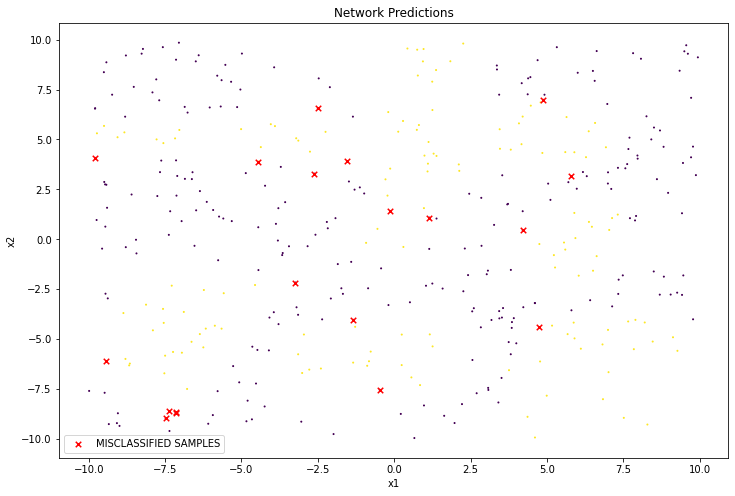

In [47]:
### Plot
x1 = all_inputs.squeeze().cpu().numpy()[:, 0]
x2 = all_inputs.squeeze().cpu().numpy()[:, 1]
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

fig, ax = plt.subplots(figsize=(12,8))
# Plot predictions
ax.scatter(x1, x2, c=y_pred, s=1, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Network Predictions')
# Mark wrong outputs
error_mask = y_pred != y_true
ax.scatter(x1[error_mask], x2[error_mask], color='red', s=30, marker='x', label='MISCLASSIFIED SAMPLES')
plt.legend()
fig.show()